<a href="https://colab.research.google.com/github/magasbakary01/covid_TB/blob/main/AI4PH050123.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Severe perinatal outcomes prediction using Artificial Intelligence on an hospitalar database from Burundi

**Questions for the tutors:**


1.   Is it possible to use a colab notebook as a deliverable for the evaluation?->answer: a report is expected, seeing our work the 12/12/2022: we could be at the limit between a practical work and a proposal for further research at the end.
2.   Other?



**Ideas to keep in mind and to share:**


1.   Observation of the missing values: it gives an interesting vision on how the e-Health tool is used by providers (e.g. maternal death with 100% of missing values), it could be a mean for the developper to improve the tool (by working on the "taboos", by simplifying the tool: e.g. prematurity with a lot of missing values but information available on the term at admission which is well filled). This observation associated with a socio-anthropological study could be interesting.
->We have to check is the data are not elsewhere, the data way between entry and extraction (storage at the MoH): try to fin/systems that are not connected
2.   Information system for patient record more that stats
3. Pr Giorgi: do a choice during your work time, we can use a simple approach to analyse data


In [2]:
# Chargement du fichier dans colab
from google.colab import files
uploaded = files.upload()


Saving Data_extracted_V3 31122022.csv to Data_extracted_V3 31122022.csv


## Part1: Database importation







In [3]:
# Importation du fichier
import pandas as pd
import numpy as np
import io
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil.relativedelta import relativedelta
from datetime import date
now = date.today()
df = pd.read_csv(io.BytesIO(uploaded['Data_extracted_V3 31122022.csv']))
#df.head()


In [4]:
import pandas as pd

## Part 2: Getting started with the Database, here a descrption to facilitate the cleaning process. 


*   10547 patients
*   45 variable keys
* 3 big classes of variables, that we will name: "RF=risk factors", "PO=perinatal outcomes", "EC=exclusion criterias". So, when we rename the variables, to facilitate our work we can add "RF", "PO" and "EC".
* new variables creation from the df (e.g. age at admission) and these variables will integrate a category (RF, PO or EC)
* some variables are only usefull to create a new variable (e.g. DDN) so they will not integrate a category.
* some variables will not be useful: SEX
* some variables have to be well defined (Armel): DATEDEBUT, admission_type
* missing value analisis result in: 
    -a first analysis of data quality: 
    -the decision of not using variables with nearly 100% of missing values (it probably signify the healthcare workers do not fill this information, it is a problem of data quality): PRE_ECLAMPSIA, PMTCT, PALU, MATERNAL_DEATH, HEMORRHAGIA_POSTPARTUM. Somme of these data would have been important (perinatal outcome).






## Our Variable Dictionary (to be checked and completed by the Team):
**ID**: the patient identification number 
**DDN**: patient date of birth, we could use it to calculate age at delivery and name the variable AGE_FR (Marielle)
**Sex**: patient sex, I suggest we delete it. (Marielle)                                 
**DATEDEBUT**: a date and an hour, it is the date of the admission of the patient.                         
**Date_Accouchement**: probable date of delivery (**ARMEL has to extract the real delivery date**), we delete it (Armel)
**Eutocique**: normal delivery (on y touche pas à priori on ne l'utilisera pas)
**Distocique**: complicated delivery (include vaginal and C-section both?we have to cross the data with CAESERIAN to check). I wonder if we should use it (?) (idem on y touche pas)                      
**CAESERIAN**: perinatal outcome: delivery by C-section. We have to transform it in a categorical variable and name it CAESERIAN_PO (Armel)
**admission_type**: this variable informs us if the patient were referred from a peripheral health centre or if she entered directly from home. We could use this variable to create a categorical variable named REFERRED_FR (Marielle)                  
**Gestity**: patient number of pregnancies (childbirths but also abortions, ectopic pregnancies will enter in this count), ** cannot be null (replace "nan" by 1?)**. We have to discuss if we use it as an interger or if we transform it in a categorical variable. (Ali)                          
**Parity**: patient number of childbirths (can be null), a number between 0 and 15 (could be extremely rarely more). A nullipare (0) is at risk, a multipare is at risk (>4). **We should create a new categorical variable (Armel will share with us the risk factors for Burundi)**. (Ali)                            
**CHILDALIVE**: number of the patient's children that are still alive, it depend on the number of childbirths the patient declared. It could be interesting to transform this data using the Parity variable to calculate the number of the patient's children who died (Parity - CHILDALIVE), we could transform the variable in a **categorical variable** yes(at least 1 infant died)/no and rename it CHILDDEATH_FR (Ali)
**ABORTION**: a risk factor: the number of abortion the patient declared(medical history). Replane nan by 0. We can create a categorical variable yes/no and rename it ABORTION_FR  (Armel)                      
**DELIVERYAGE**: Term of the pregnancy at admission in weeks completed with days (between 1 and 6). Exemples of data: '40 3','40 1',nan,'39'. We could only keep the weeks and delete the days. We could convert the variable as an integer and rename it DELIVERYAGE_RF. We will have to create the variable PREMATURITY_EC (when the term is < 37) to exclude the prematurity cases.  (Marielle)               
**HIGHRISK_PREGNANCY**: a risk factor: the patient classified at high risk by the provider (what are the criterias?). Numbers are entered (e.g.: 1.0) but I need to understand better the signification (Does "1.0" means there is only 1 risk factor?)  entered as a float (to be transformed as int and then as a categorical variable) and renamed HIGHRISK_PREGNANCY_FR  (Armel)                 
**PRE_ECLAMPSIA**: too much missing values, I suggest we abandon  (Armel to find a reason, we delete it for the AI)                
**PMTCT**: too much missing values, I suggest we abandon it (Armel to find a reason, here it is about HIV treatment during pregnancy, we delete it for the AI)                         
**NUMBER_CPN**: a risk factor: the number of antenatal visits the patients did, 4 are recommended, can be null if the women never went to antenatal visits. Well filled with numbers between 1 and 4, and "nan". I wonder if "nan" are not "0". We should transform the variable as an integer and rename it NUMBER_CPN_FR. **We can discuss together: if we consider missing values as "0" (Armel will ask to the providers)**, if we create a new categorical variable depending on the number of ANC visits (Armel).                      
**IPT_DOSE**: a risk factor: the fact to have received an intermittent prophylaxis treatment during pregnancy. We have to create a categorical variable renames bases on the "OUI" named IPT_DOSE_FR  (Ali)                       
**PALU**: 100% of missing values, we delete it after **Armel check and confirm it** (Armel)                           
**VIH**: a risk factor: HIV test result at patient admission "+" or "-" or "nan". We have to create a categorical variable HIV_POS_FR (Aboubacar)  
**SYPHILIS**: a risk factor: syphilis test result at patient admission "+" or "-" or "nan". We have to create a categorical variable SYPHILIS_POS_FR (Aboubacar)
**BORN_ALIVE**: a neonatal outcome: the neonate were born alive or dead. Well filled, we have to transform it in a categorical variable renamed BORN_ALIVE_PO (Ali)                       
**APGAR_TOTAL_5**: a neonatal outcome: Apgar score at 5 minutes, it is a number between 0 and 10, we should create a new categorical variable APGAR_TOTAL_5_PO for the Apgar scores < 7 ("1" vs "0"). Becareful here when we will treat the missing values because if missing values are replaced by 0 it will tell the neonate had a bad Apgar score. (Marielle)                  
**CHILD_REANIMATION**: a neonatal outcome: at birth the neonate benefitted from a support to help him breathing. Data were entered manually so we have some heterogenous results (e.g. "oui","NON" ). We should extract all the "oui", "OUI",... to create a new variable named CHILD_REANIMATION_PO (Ali)               
**MATERNAL_DEATH**: a maternal outcome, 100% of missing values, I suggest we do not use the variable, **Armel will check and probably do a new extraction          **        
**PREMATURE**: exclusion criteria but nearly 100% of missing values, I suggest we do not use this variable (compensated by the use of the variable DELIVERYAGE) (Marielle)                     
**HEMORRHAGIA_POSTPARTUM**: a maternal outcome, the patient presents an important (>500ml) bleeding after delivery, nearly 100% of missing values, we delete (Armel)               
**GEMELITE**: gemelar pregnancy known at admission. The problem is that data were entered manually so we have heterogenous results (e.g. "non","NON","Oui" ). We have to extract the "Oui", "OUI"...to create a new categorical variable named GEMELITE_PRESENCE_EC) (Aboubacar)               
**BCF**: fetal heart beat presence at admission filled with "+" or "-" or "nan" (to be transformed in a categorical variable like "1" and "0" to extract patient with intra-uterine fetal deaths, to rename in BCF_ABSENCE_EC) (Marielle)                             
**METRORHAGIE**: the patient presents a vaginal bleeding at admission, nearly 100% of missing values, we delete (Armel)                
**PREMATURE_RUPTUREOFMEMBRANES**: when the water pouch opens before labour, nearly 100% of missing values, we delete (Armel to check why and to delete)   
**MATERNAL_HEIGHT**: maternal height at admission. The problem is that data were entered manually so we have some heterogenous results (e.g. "1.50","153" ). This variable should be transformed as an integer and have the same unit cm or m (we have to discuss on how to clean the variable) (Aboubacar)               
**MATERNAL_WEIGHT**: maternal weight at admission in kg. The problem is that data were entered manually so we have some (not so much) heterogenous results (e.g. "50","53kg" ). This variable should be transformed as an integer (we have to discuss on how to clean the variable) (Aboubacar)                
**BRACHIAL_PERIMETER**: brachial perimeter in cm at admission to detect maternal malnutrition, the problem is that data were entered manually so we have some (not so much) heterogenous results (e.g. "23","23cm" ). This variable should be transformed as an integer (we have to discuss on how to clean the variable) (Aboubacar)              
**UTERINE_HEIGHT**: uterine height at admission in cm (could be between 15 and 45cm), the problem is that data were entered manually so we have very heterogenous results (e.g. "32cm", "32CM", "32"). This variable should be transformed as an integer (we have to discuss on how to clean the variable, is it even possible?) (Aboubacar)                 
**CONJUNCTIVA**: colour of the patient eye's conjuctiva to detect an anaemia at admission, data entered manually so very heterogenous (e.g.: "COLOREE", "Colorée oui", "colorée"). This variable should be transformed as a categorical variable: "colorée"=1 and O if not (we have to discuss on how to clean the variable, is it even possible?) (Armel)                         
**DILATATION_COL_DEBUT**: cervical dilatation at admission in cm (between 0 and 10), the problem is that data were entered manually so we have very heterogenous results (e.g. "fermé", "10CM", "4cm"). This variable should be transformed as an integer with numbers between 0 and 10 (we have to discuss on how to clean the variable, is it even possible?) (Marielle)            
**ETAT_BASSIN**: numbers are entered (e.g.: 2.0) 1= normal 2=limite 3= retreci but I need to understand better the signification as there is also the water-pouch just before, entered as a float (to be transformed as a categorical variable) (Marielle)                                    
**BLOOD_PRESSURE**: maternal blood pressure at admission as an object, associating diastolic and systolic measurements separated by "/", entered manually so we have data in cmHg and in mmHg (several options to extract the information: we only extract the diastolic bp measure and we uniformize the result in mmHg OR it is possible to separate diastolic and systolic to create 2 separate data. In this case, it would be interesting to calculate and use the mean)  (Ali)                  
**HEART_FREQUENCY**: maternal heart freaquency in bpm at admission, entered as an object (to be transformed as an integer, rename HEART_FREQUENCY_FR) (Ali)                 
**MATERNAL_TEMPERATURE**: maternal temperature in celsius degree at admission, entered as an object (to be transformed in a float number, rename MATERNAL_TEMPERATURE_FR) (Ali)             
**WATER_POUCH**: "poche des eaux", numbers are entered 1=intacte 2 =rompue(e.g.: 1.0, 2.0) but I need to understand the correspondance of these numbers (**Armel will define it?**), entered as a float (to be transformed as a categorical variable) (Marielle)                           
**POCHE**: numbers are entered (e.g.: 2.0) but I need to understand better the signification as there is also the water-pouch just before (Armel?), entered as a float (to be transformed as a categorical variable)                            
**PARTO_DILATATION**: several dilatation measurements during labour monitoring but associated with a complex number which probably gives temporal information (**Armel can you give information so we can understand how to treat this variable?**)               


ID: the patient identification number

1.   Explicative variables (20):

-DDN: patient date of birth, we could use it to calculate age at delivery and name the variable **AGE_FR** (Marielle)

-Date_Accouchement: probable date of delivery (ARMEL has to extract the real delivery date), we delete it (Armel) 

-admission_type: this variable informs us if the patient were referred from a peripheral health centre or if she entered directly from home. We could use this variable to create a categorical variable named **REFERRED_FR** (Marielle)

-**Parity**: patient number of childbirths (can be null), a number between 0 and 15 (could be extremely rarely more). A nullipare (0) is at risk, a multipare is at risk (>4). We should create a new categorical variable (Armel will share with us the risk factors for Burundi). (Ali)

-HIGHRISK_PREGNANCY: a risk factor: the patient classified at high risk by the provider (what are the criterias?). Numbers are entered (e.g.: 1.0) but I need to understand better the signification (Does "1.0" means there is only 1 risk factor?) entered as a float (to be transformed as int and then as a categorical variable) and renamed **HIGHRISK_PREGNANCY_FR** (Armel)

-NUMBER_CPN: a risk factor: the number of antenatal visits the patients did, 4 are recommended, can be null if the women never went to antenatal visits. Well filled with numbers between 1 and 4, and "nan". I wonder if "nan" are not "0". We should transform the variable as an integer and rename it **NUMBER_CPN_FR**. We can discuss together: if we consider missing values as "0" (Armel will ask to the providers), if we create a new categorical variable depending on the number of ANC visits (Armel).

-**MATERNAL_HEIGHT**: maternal height at admission. The problem is that data were entered manually so we have some heterogenous results (e.g. "1.50","153" ). This variable should be transformed as an integer and have the same unit cm or m (we have to discuss on how to clean the variable) (Aboubacar)

-**MATERNAL_WEIGHT**: maternal weight at admission in kg. The problem is that data were entered manually so we have some (not so much) heterogenous results (e.g. "50","53kg" ). This variable should be transformed as an integer (we have to discuss on how to clean the variable) (Aboubacar)

-**BRACHIAL_PERIMETER**: brachial perimeter in cm at admission to detect maternal malnutrition, the problem is that data were entered manually so we have some (not so much) heterogenous results (e.g. "23","23cm" ). This variable should be transformed as an integer (we have to discuss on how to clean the variable) (Aboubacar)

-**UTERINE_HEIGHT**: uterine height at admission in cm (could be between 15 and 45cm), the problem is that data were entered manually so we have very heterogenous results (e.g. "32cm", "32CM", "32"). This variable should be transformed as an integer (we have to discuss on how to clean the variable, is it even possible?) (Aboubacar)

-**DILATATION_COL_DEBUT**: cervical dilatation at admission in cm (between 0 and 10), the problem is that data were entered manually so we have very heterogenous results (e.g. "fermé", "10CM", "4cm"). This variable should be transformed as an integer with numbers between 0 and 10 (we have to discuss on how to clean the variable, is it even possible?) (Marielle)

-**BLOOD_PRESSURE**: maternal blood pressure at admission as an object, associating diastolic and systolic measurements separated by "/", entered manually so we have data in cmHg and in mmHg (several options to extract the information: we only extract the diastolic bp measure and we uniformize the result in mmHg OR it is possible to separate diastolic and systolic to create 2 separate data. In this case, it would be interesting to calculate and use the mean) (Ali)

-**HEART_FREQUENCY**: maternal heart freaquency in bpm at admission, entered as an object (to be transformed as an integer, rename HEART_FREQUENCY_FR) (Ali)

-**MATERNAL_TEMPERATURE**: maternal temperature in celsius degree at admission, entered as an object (to be transformed in a float number, rename MATERNAL_TEMPERATURE_FR) (Ali)

-**WATER_POUCH**: "poche des eaux", numbers are entered 1=intacte 2 =rompue(e.g.: 1.0, 2.0) but I need to understand the correspondance of these numbers (Armel will define it?), entered as a float (to be transformed as a categorical variable) (Marielle)


2.  Exclusion variables:

-DELIVERYAGE: Term of the pregnancy at admission in weeks completed with days (between 1 and 6). Exemples of data: '40 3','40 1',nan,'39'. We could only keep the weeks and delete the days. We could convert the variable as an integer and rename it DELIVERYAGE_RF. We will have to create the variable **PREMATURITY_EC** (when the term is < 37) to exclude the prematurity cases. (Marielle)

-GEMELITE: gemelar pregnancy known at admission. The problem is that data were entered manually so we have heterogenous results (e.g. "non","NON","Oui" ). We have to extract the "Oui", "OUI"...to create a new categorical variable named **GEMELITE_PRESENCE_EC**) (Aboubacar)

-BCF: fetal heart beat presence at admission filled with "+" or "-" or "nan" (to be transformed in a categorical variable like "1" and "0" to extract patient with intra-uterine fetal deaths, to rename in **BCF_ABSENCE_EC**) (Marielle)

3.  Outcome composite variable using (focusing on neonates outcomes):
-BORN_ALIVE: a neonatal outcome: the neonate were born alive or dead. Well filled, we have to transform it in a categorical variable renamed **BORN_ALIVE_PO (Ali)**

-APGAR_TOTAL_5: a neonatal outcome: Apgar score at 5 minutes, it is a number between 0 and 10, we should create a new categorical variable **APGAR_TOTAL_5_PO** for the Apgar scores < 7 ("1" vs "0"). Becareful here when we will treat the missing values because if missing values are replaced by 0 it will tell the neonate had a bad Apgar score. (Marielle)

-CHILD_REANIMATION: a neonatal outcome: at birth the neonate benefitted from a support to help him breathing. Data were entered manually so we have some heterogenous results (e.g. "oui","NON" ). We should extract all the "oui", "OUI",... to create a new variable named **CHILD_REANIMATION_PO** (Ali)



In [5]:
#df.info()

In [6]:
#Number of colums and rows
df.shape

(10548, 26)

# Part 3: Preprocessing the data

## 1.Missing Values

In [7]:
#Missing value visualization
df.isnull().sum()

ID                         0
DDN                        0
date_debut                 0
Outcome                   23
Date_Accouchement        117
admission_type          1378
Parity                    98
HIGHRISK_PREGNANCY      8431
NUMBER_CPN               219
MATERNAL_HEIGHT          300
MATERNAL_WEIGHT          334
BRACHIAL_PERIMETER       760
UTERINE_HEIGHT           391
DILATATION_COL_DEBUT     156
BLOOD_PRESSURE           423
HEART_FREQUENCY          406
MATERNAL_TEMPERATURE     310
WATER_POUCH             2366
DELIVERYAGE             1427
GEMELITE                5330
BCF                      237
BORN_ALIVE                56
APGAR_TOTAL_5            442
CHILD_REANIMATION        938
DIADNOSTIC_CODE          108
DIADNOSTIC               108
dtype: int64

## 2.Variable rename

In [8]:
#We rename some variables:
df=df.rename(columns={"": ""})
#print(df)


In [9]:
# Use str.split and str.join and astype
df['DELIVERYAGE'] = df['DELIVERYAGE'].str.split(' ').str.join('.')
df['DELIVERYAGE'] = df['DELIVERYAGE'].fillna(0)
df['DELIVERYAGE'] = pd.to_numeric(df['DELIVERYAGE'], errors='coerce').astype(int)
df['DELIVERYAGE']

0        38
1        36
2        40
3         0
4        38
         ..
10543    37
10544    33
10545    41
10546    32
10547     0
Name: DELIVERYAGE, Length: 10548, dtype: int64

## 3.New variable creation

To discuss between us:

*PREMATURITY_EC: Missing values of DELIVERYAGE have been coded "O" and then considered as PREMATURITY_EC=1: Do we keep it like that?

*AGE_FR, Parity: I failed to transform it as an integer, Python says "Cannot convert non-finite values (NA or inf) to integer": how do we deal with it?

*HIGH RISK PREGNANCY: Why do you want to delete it? Too much "1.0"?

In [10]:
#Prematurity (with DELIVERYAGE, if DELIVERYAGE<37)

df['PREMATURITY_EC'] = np.where(df['DELIVERYAGE']<37, 1, 0)

In [11]:
#Patient age at admission (with DDN and Date_Accouchement): AGE_FR
# Computing of age
df['DDN'] = pd.to_datetime(df['DDN'], errors='coerce')
df['Date_Accouchement'] = pd.to_datetime(df['Date_Accouchement'], errors='coerce')

df['AGE_FR'] = (df['Date_Accouchement']-df['DDN'])/np.timedelta64(1,'Y')
df['AGE_FR'] = df['AGE_FR'].round(0)
#df['AGE_FR'] = df['AGE_FR'].astype(int)
df['AGE_FR'].head()

0    36.0
1    23.0
2    40.0
3    22.0
4    34.0
Name: AGE_FR, dtype: float64

In [12]:
# Parity, renamed PARITY_FR
df['Parity'] = df['Parity'].replace('P0','0')
df['Parity'] = df['Parity'].replace('.3','3')
df['Parity'] = df['Parity'].replace('O','0')
df['Parity'] = df['Parity'].replace('P1','1')
df['Parity'] = df['Parity'].replace('P4','4')
df['Parity'] = df['Parity'].replace('p2','2')
df['Parity'] = df['Parity'].replace('o','0')
df['Parity'] = df['Parity'].replace('P5','5')
df['Parity'] = df['Parity'].replace('P2','2')
df['Parity']=df['Parity'].fillna(0)
df["Parity"].astype(np.int64)
df['PARITY_FR'] = pd.to_numeric(df['Parity'], errors='coerce').astype(int)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df["PARITY_FR"].astype(np.int64)

0        4
1        0
2        5
3        1
4        5
        ..
10543    0
10544    1
10545    6
10546    0
10547    1
Name: PARITY_FR, Length: 10548, dtype: int64

In [13]:
# Higth risk factor ( we suggest to delete this variable...->I do not think so). I transformed it as a categorical variable and I renamed it HIGHRISK_PREGNANCY_FR
df['HIGHRISK_PREGNANCY'].describe()
df['HIGHRISK_PREGNANCY'] = df['HIGHRISK_PREGNANCY'].fillna(0)
df['HIGHRISK_PREGNANCY_FR'] = df['HIGHRISK_PREGNANCY'].round(0).astype(int)
#df['HIGHRISK_PREGNANCY_FR'].tolist()

In [14]:
#NUMBER_CPN_FR
df['NUMBER_CPN']=df['NUMBER_CPN'].fillna(0)
df['NUMBER_CPN'] = df['NUMBER_CPN'].replace('normal','4')
df['NUMBER_CPN'] = df['NUMBER_CPN'].replace('.3','3')
df['NUMBER_CPN'] = df['NUMBER_CPN'].replace('4FOIS','4')
df['NUMBER_CPN'] = df['NUMBER_CPN'].replace('-','0')
df['NUMBER_CPN'] = df['NUMBER_CPN'].replace('b+','4')
df['NUMBER_CPN'] = df['NUMBER_CPN'].replace('OUI','4')
df["NUMBER_CPN"].astype(np.int64)
df["NUMBER_CPN_FR"]=df["NUMBER_CPN"]
df['NUMBER_CPN_FR'].describe

<bound method NDFrame.describe of 0        3
1        3
2        3
3        2
4        3
        ..
10543    3
10544    3
10545    3
10546    3
10547    3
Name: NUMBER_CPN_FR, Length: 10548, dtype: object>

In [15]:
# Apgar->See here I do not understand the error messages
df['APGAR_TOTAL_5']=df['APGAR_TOTAL_5'].fillna(7)
df['APGAR_TOTAL_5'] = pd.to_numeric(df['APGAR_TOTAL_5'], errors='coerce')
df = df.dropna(subset=['APGAR_TOTAL_5'])
df['APGAR_TOTAL_5'] = df['APGAR_TOTAL_5'].astype(int)


<ipython-input-15-fa371187ff6c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['APGAR_TOTAL_5'] = df['APGAR_TOTAL_5'].astype(int)


In [16]:
df['APGAR_TOTAL_5'].astype(np.int64)

0        10
1        10
2        10
3        10
4        10
         ..
10543     4
10544    10
10545    10
10546    10
10547    10
Name: APGAR_TOTAL_5, Length: 10487, dtype: int64

In [17]:
#APGAR_TOTAL_5_PO creation: for the Apgar scores < 7 ("1" vs "0")
#To be done
df['APGAR_TOTAL_5'] = np.where(df['APGAR_TOTAL_5']<7, 1, 0)

<ipython-input-17-ed3a92d460de>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['APGAR_TOTAL_5'] = np.where(df['APGAR_TOTAL_5']<7, 1, 0)


In [18]:
#CHILD_REANIMATION_PO
df['CHILD_REANIMATION'] = df['CHILD_REANIMATION'].replace('NON','0')
df['CHILD_REANIMATION'] = df['CHILD_REANIMATION'].replace('non','0')
df['CHILD_REANIMATION'] = df['CHILD_REANIMATION'].replace('NaN','0')
df['CHILD_REANIMATION'] = df['CHILD_REANIMATION'].replace('--','0')
df['CHILD_REANIMATION'] = df['CHILD_REANIMATION'].replace('oui','1')
df['CHILD_REANIMATION'] = df['CHILD_REANIMATION'].replace('SANS','0')
df['CHILD_REANIMATION'] = df['CHILD_REANIMATION'].replace('OUI','1')
df['CHILD_REANIMATION'] = df['CHILD_REANIMATION'].replace('Non','0')
df['CHILD_REANIMATION'] = df['CHILD_REANIMATION'].replace('ASPIRATION','0')
df['CHILD_REANIMATION'] = df['CHILD_REANIMATION'].replace('-','0')
df['CHILD_REANIMATION'] = df['CHILD_REANIMATION'].replace('OUI TRANSFERT EN SCE DE NÉO-NAT0LOGIE','1')
df['CHILD_REANIMATION'] = df['CHILD_REANIMATION'].replace('-NON','0')
df['CHILD_REANIMATION'] = df['CHILD_REANIMATION'].replace('no,n','0')
df['CHILD_REANIMATION'] = df['CHILD_REANIMATION'].replace('pas','0')
df['CHILD_REANIMATION'] = df['CHILD_REANIMATION'].replace('NOM','0')
df['CHILD_REANIMATION'] = df['CHILD_REANIMATION'].replace('nnon','0')
df['CHILD_REANIMATION'] = df['CHILD_REANIMATION'].replace('NONS','0')
df['CHILD_REANIMATION'] = df['CHILD_REANIMATION'].replace('=NON','0')
df['CHILD_REANIMATION'] = df['CHILD_REANIMATION'].replace('BEBE   NZEYIMANA','0')
df['CHILD_REANIMATION'] = df['CHILD_REANIMATION'].replace('NONO','0')
df['CHILD_REANIMATION'] = df['CHILD_REANIMATION'].replace('NBON','0')
df['CHILD_REANIMATION'] = df['CHILD_REANIMATION'].replace('QUI','1')
df['CHILD_REANIMATION'] = df['CHILD_REANIMATION'].replace('OUI MALGRÉ L,ECHEC','1')
df['CHILD_REANIMATION'] = df['CHILD_REANIMATION'].replace('NO,N','0')
df['CHILD_REANIMATION'] = df['CHILD_REANIMATION'].replace('PAS','0')
df['CHILD_REANIMATION'] = df['CHILD_REANIMATION'].replace('Norm','0')
df['CHILD_REANIMATION'] = df['CHILD_REANIMATION'].replace('-non','0')
df['CHILD_REANIMATION'] = df['CHILD_REANIMATION'].replace('TRANSFERER EN NEONATOLOGIE CAR LA MECONIAL','1')
df['CHILD_REANIMATION'] = df['CHILD_REANIMATION'].replace('FAIT ET CONTINUE PLUS DE 2H','1')
df['CHILD_REANIMATION'] = df['CHILD_REANIMATION'].replace('transfert en neonatologie','1')
df['CHILD_REANIMATION'] = df['CHILD_REANIMATION'].replace('NONNON','0')
df['CHILD_REANIMATION'] = df['CHILD_REANIMATION'].replace('npon','0')
df['CHILD_REANIMATION'] = df['CHILD_REANIMATION'].replace('aspiration','1')
df['CHILD_REANIMATION'] = df['CHILD_REANIMATION'].replace('RAS','0')
df['CHILD_REANIMATION'] = df['CHILD_REANIMATION'].replace('BEBE  NAHIMANA','0')
df['CHILD_REANIMATION'] = df['CHILD_REANIMATION'].replace('BEBE  NAHIMANA','0')
df['CHILD_REANIMATION'] = df['CHILD_REANIMATION'].replace(',non','0')
df['CHILD_REANIMATION'] = df['CHILD_REANIMATION'].replace('NON SANS','0')
df['CHILD_REANIMATION'] = df['CHILD_REANIMATION'].replace('NONNONNON','0')
df['CHILD_REANIMATION'] = df['CHILD_REANIMATION'].replace('nonnon','0')
df['CHILD_REANIMATION'] = df['CHILD_REANIMATION'].replace('OUI PAR ASPIRATION','1')
df['CHILD_REANIMATION'] = df['CHILD_REANIMATION'].replace('ras','0')
df['CHILD_REANIMATION'] = df['CHILD_REANIMATION'].replace('OUI:ASPIRATION','1')
df['CHILD_REANIMATION'] = df['CHILD_REANIMATION'].replace('OUI:APSIRATION','1')
df['CHILD_REANIMATION'] = df['CHILD_REANIMATION'].replace('OUI: ASPIRATION','1')
df['CHILD_REANIMATION'] = df['CHILD_REANIMATION'].replace('NO','0')
df['CHILD_REANIMATION'] = df['CHILD_REANIMATION'].replace('aspiration naso-pharingée','0')
df['CHILD_REANIMATION'] = df['CHILD_REANIMATION'].replace('OUI;ASPIRATION','1')
df['CHILD_REANIMATION'] = df['CHILD_REANIMATION'].replace('oui: aspiration','1')
df['CHILD_REANIMATION'] = df['CHILD_REANIMATION'].replace('NON:ASPIRATION','0')
df['CHILD_REANIMATION'] = df['CHILD_REANIMATION'].replace('NON:ASPIRATON','0')
df['CHILD_REANIMATION'] = df['CHILD_REANIMATION'].replace('ASPIRATION SEULEMENT','1')
df['CHILD_REANIMATION'] = df['CHILD_REANIMATION'].replace(',NON','0')
df['CHILD_REANIMATION'] = df['CHILD_REANIMATION'].replace('NON: ASPIRATION','0')
df['CHILD_REANIMATION'] = df['CHILD_REANIMATION'].replace('oui+aspiration','1')
df['CHILD_REANIMATION'] = df['CHILD_REANIMATION'].replace('non:aspiration','0')
df['CHILD_REANIMATION'] = df['CHILD_REANIMATION'].replace('normal','0')
df['CHILD_REANIMATION'] = df['CHILD_REANIMATION'].replace('NIN','0')
df['CHILD_REANIMATION'] = df['CHILD_REANIMATION'].replace('NNON','0')
df['CHILD_REANIMATION'] = df['CHILD_REANIMATION'].replace('on','0')
df['CHILD_REANIMATION'] = df['CHILD_REANIMATION'].replace("oui: l'aspiration",'1')
df['CHILD_REANIMATION'] = df['CHILD_REANIMATION'].replace("OUI AVEC AMBU+O2",'1')
df['CHILD_REANIMATION'] = df['CHILD_REANIMATION'].replace("NON:ASPIRARION",'0')
df['CHILD_REANIMATION'] = df['CHILD_REANIMATION'].replace("normale",'0')
df['CHILD_REANIMATION'] = df['CHILD_REANIMATION'].replace("non;aspiration",'0')
df['CHILD_REANIMATION'] = df['CHILD_REANIMATION'].replace("oui;aspiration",'1')
df['CHILD_REANIMATION'] = df['CHILD_REANIMATION'].replace("NON;ASPARATION",'1')
df['CHILD_REANIMATION'] = df['CHILD_REANIMATION'].replace("-OUI",'1')

df['CHILD_REANIMATION']=df['CHILD_REANIMATION'].fillna(0)
df['CHILD_REANIMATION'] = df['CHILD_REANIMATION'].astype(int)

#df['CHILD_REANIMATION'].tolist()

<ipython-input-18-db7c314d2c24>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CHILD_REANIMATION'] = df['CHILD_REANIMATION'].replace('NON','0')


In [19]:
df['CHILD_REANIMATION'].describe()



count    10487.000000
mean         0.063889
std          0.244566
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: CHILD_REANIMATION, dtype: float64

In [20]:
#It seems that there no gemelar pregnancy (we could discuss to delete it)
df['GEMELITE'] = np.where(df['GEMELITE']=="OUI", "1", "0")
df['GEMELITE'] = df['GEMELITE'].astype(int)
df['GEMELITE'].describe()

count    10487.000000
mean         0.008391
std          0.091223
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: GEMELITE, dtype: float64

In [21]:
#BCF_EC
df['BCF'] = np.where(df['BCF']=="+", "1", "0")
df['BCF_EC'] = df['BCF']
df['BCF_EC'] = df['BCF_EC'].astype(int)
df['BCF_EC'].describe()

count    10487.000000
mean         0.946124
std          0.225784
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: BCF_EC, dtype: float64

In [22]:
#val = df['MATERNAL_HEIGHT'].mean(axis=0,skipna=True)
#print(val)
#df['MATERNAL_HEIGHT'].head()

In [23]:
# maternal_height: there is an error message here (how to deal with NaN?)
df['MATERNAL_HEIGHT'] = df['MATERNAL_HEIGHT'].replace('.','0')
df['MATERNAL_HEIGHT'] = df['MATERNAL_HEIGHT'].replace(',','0')
df['MATERNAL_HEIGHT'] = df['MATERNAL_HEIGHT'].replace('1.56','156')
df['MATERNAL_HEIGHT'] = df['MATERNAL_HEIGHT'].replace('1.55','155')
df['MATERNAL_HEIGHT'] = df['MATERNAL_HEIGHT'].replace('1.60','160')
df['MATERNAL_HEIGHT'] = df['MATERNAL_HEIGHT'].replace('1.63','163')
df['MATERNAL_HEIGHT'] = df['MATERNAL_HEIGHT'].replace('1.50','150')
df['MATERNAL_HEIGHT'] = df['MATERNAL_HEIGHT'].replace('1.54','154')
df['MATERNAL_HEIGHT'] = df['MATERNAL_HEIGHT'].replace('1.58','158')
df['MATERNAL_HEIGHT'] = df['MATERNAL_HEIGHT'].replace('1.59','159')
df['MATERNAL_HEIGHT'] = df['MATERNAL_HEIGHT'].replace('1.47','147')
df['MATERNAL_HEIGHT'] = df['MATERNAL_HEIGHT'].replace('1.67','167')
df['MATERNAL_HEIGHT'] = df['MATERNAL_HEIGHT'].replace('1.52','152')
df['MATERNAL_HEIGHT'] = df['MATERNAL_HEIGHT'].replace('1,57','157')
df['MATERNAL_HEIGHT'] = df['MATERNAL_HEIGHT'].replace('1.66','166')
df['MATERNAL_HEIGHT'] = df['MATERNAL_HEIGHT'].replace('1.61','161')
df['MATERNAL_HEIGHT'] = df['MATERNAL_HEIGHT'].replace('1,50','150')
df['MATERNAL_HEIGHT'] = df['MATERNAL_HEIGHT'].replace('1.64','164')
df['MATERNAL_HEIGHT'] = df['MATERNAL_HEIGHT'].replace('1,56','156')
df['MATERNAL_HEIGHT'] = df['MATERNAL_HEIGHT'].replace('1.45','145')
df['MATERNAL_HEIGHT'] = df['MATERNAL_HEIGHT'].replace('1.68','168')
df['MATERNAL_HEIGHT'] = df['MATERNAL_HEIGHT'].replace('1.53','153')
df['MATERNAL_HEIGHT'] = df['MATERNAL_HEIGHT'].replace('1.70','170')
df['MATERNAL_HEIGHT'] = df['MATERNAL_HEIGHT'].replace('1.49','149')
df['MATERNAL_HEIGHT'] = df['MATERNAL_HEIGHT'].replace('1.51','151')
df['MATERNAL_HEIGHT'] = df['MATERNAL_HEIGHT'].replace('1.65','165')
df['MATERNAL_HEIGHT'] = df['MATERNAL_HEIGHT'].replace('1.46','146')
df['MATERNAL_HEIGHT'] = df['MATERNAL_HEIGHT'].replace('1.71','171')
df['MATERNAL_HEIGHT'] = df['MATERNAL_HEIGHT'].replace('1.38','138')
df['MATERNAL_HEIGHT'] = df['MATERNAL_HEIGHT'].replace('1.40','140')
df['MATERNAL_HEIGHT'] = df['MATERNAL_HEIGHT'].replace('1.42','142')
df['MATERNAL_HEIGHT'] = df['MATERNAL_HEIGHT'].replace('1.72','172')
df['MATERNAL_HEIGHT'] = df['MATERNAL_HEIGHT'].replace('1,60','160')
df['MATERNAL_HEIGHT'] = df['MATERNAL_HEIGHT'].replace('1,45','145')
df['MATERNAL_HEIGHT'] = df['MATERNAL_HEIGHT'].replace('1,70','170')
df['MATERNAL_HEIGHT'] = df['MATERNAL_HEIGHT'].replace('1,66','166')
df['MATERNAL_HEIGHT'] = df['MATERNAL_HEIGHT'].replace('1,58','158')
df['MATERNAL_HEIGHT'] = df['MATERNAL_HEIGHT'].replace('1,52','152')
df['MATERNAL_HEIGHT'] = df['MATERNAL_HEIGHT'].replace('1.69','169')
df['MATERNAL_HEIGHT'] = df['MATERNAL_HEIGHT'].replace('1.75','175')
df['MATERNAL_HEIGHT'] = df['MATERNAL_HEIGHT'].replace('1,68','168')
df['MATERNAL_HEIGHT'] = df['MATERNAL_HEIGHT'].replace('1,59','159')
df['MATERNAL_HEIGHT'] = df['MATERNAL_HEIGHT'].replace('1,54','154')
df['MATERNAL_HEIGHT'] = df['MATERNAL_HEIGHT'].replace('1.43','143')
df['MATERNAL_HEIGHT'] = df['MATERNAL_HEIGHT'].replace('1.44','144')
df['MATERNAL_HEIGHT'] = df['MATERNAL_HEIGHT'].replace('1,65','165')
df['MATERNAL_HEIGHT'] = df['MATERNAL_HEIGHT'].replace('1.80','180')
df['MATERNAL_HEIGHT'] = df['MATERNAL_HEIGHT'].replace('normale','165')
df['MATERNAL_HEIGHT'] = df['MATERNAL_HEIGHT'].replace('colore','165')
df['MATERNAL_HEIGHT'] = df['MATERNAL_HEIGHT'].replace('1.39','139')
df['MATERNAL_HEIGHT'] = df['MATERNAL_HEIGHT'].replace('1.78','178')
df['MATERNAL_HEIGHT'] = df['MATERNAL_HEIGHT'].replace('1,63','163')
df['MATERNAL_HEIGHT'] = df['MATERNAL_HEIGHT'].replace('110/60','160')
df['MATERNAL_HEIGHT'] = df['MATERNAL_HEIGHT'].replace('1,62','162')
df['MATERNAL_HEIGHT'] = df['MATERNAL_HEIGHT'].replace('0.58','158')
df['MATERNAL_HEIGHT'] = df['MATERNAL_HEIGHT'].replace('COURT','150')
df['MATERNAL_HEIGHT'] = df['MATERNAL_HEIGHT'].replace('1,55','155')
df['MATERNAL_HEIGHT'] = df['MATERNAL_HEIGHT'].replace('1;60','160')
df['MATERNAL_HEIGHT'] = df['MATERNAL_HEIGHT'].replace('1;56','156')
df['MATERNAL_HEIGHT'] = df['MATERNAL_HEIGHT'].replace('1,67','167')
df['MATERNAL_HEIGHT'] = df['MATERNAL_HEIGHT'].replace('1,71','171')
df['MATERNAL_HEIGHT'] = df['MATERNAL_HEIGHT'].replace('1,64','164')
df['MATERNAL_HEIGHT'] = df['MATERNAL_HEIGHT'].replace('1,61','161')
df['MATERNAL_HEIGHT'] = df['MATERNAL_HEIGHT'].replace('1,75','175')
df['MATERNAL_HEIGHT'] = df['MATERNAL_HEIGHT'].replace('1.258','158')
df['MATERNAL_HEIGHT'] = df['MATERNAL_HEIGHT'].replace('1,48','148')
df['MATERNAL_HEIGHT'] = df['MATERNAL_HEIGHT'].replace('CV','160')
df['MATERNAL_HEIGHT'] = df['MATERNAL_HEIGHT'].replace('1,74','174')
df['MATERNAL_HEIGHT'] = df['MATERNAL_HEIGHT'].replace('1,69','169')
df['MATERNAL_HEIGHT'] = df['MATERNAL_HEIGHT'].replace('1,76','176')
df['MATERNAL_HEIGHT'] = df['MATERNAL_HEIGHT'].replace('1,72','172')
df['MATERNAL_HEIGHT'] = df['MATERNAL_HEIGHT'].replace('8CM','160')
df['MATERNAL_HEIGHT'] = df['MATERNAL_HEIGHT'].replace('COLOREES','160')
df['MATERNAL_HEIGHT'] = df['MATERNAL_HEIGHT'].replace('4.60','160')
df['MATERNAL_HEIGHT'] = df['MATERNAL_HEIGHT'].replace('4.60','160')
df['MATERNAL_HEIGHT'] = pd.to_numeric(df['MATERNAL_HEIGHT'], errors='coerce')

df['MATERNAL_HEIGHT'].fillna(156)

df['MATERNAL_HEIGHT'].head()



0    156.0
1    154.0
2    156.0
3    158.0
4    155.0
Name: MATERNAL_HEIGHT, dtype: float64

In [24]:
df['MATERNAL_HEIGHT'].mean()

156.56038873073524

In [25]:
# MATERNAL_WEIGHT: here an error message, how to deal with NaN?

df['MATERNAL_WEIGHT'] = df['MATERNAL_WEIGHT'].replace('.','0')
df['MATERNAL_WEIGHT'] = df['MATERNAL_WEIGHT'].replace('55.5','55')
df['MATERNAL_WEIGHT'] = pd.to_numeric(df['MATERNAL_WEIGHT'], errors='coerce')
df['MATERNAL_WEIGHT'].fillna(df['MATERNAL_WEIGHT'].mean())

df['MATERNAL_WEIGHT'].describe()






count    10149.000000
mean        59.668263
std         25.068126
min          5.000000
25%         56.000000
50%         58.000000
75%         60.000000
max       2300.000000
Name: MATERNAL_WEIGHT, dtype: float64

In [26]:
df['BORN_ALIVE'].isnull().sum()
df['BORN_ALIVE'].fillna('openclinic.common.bornalive')


0        openclinic.common.bornalive
1        openclinic.common.bornalive
2        openclinic.common.bornalive
3        openclinic.common.bornalive
4        openclinic.common.bornalive
                    ...             
10543    openclinic.common.bornalive
10544    openclinic.common.bornalive
10545    openclinic.common.bornalive
10546    openclinic.common.bornalive
10547    openclinic.common.bornalive
Name: BORN_ALIVE, Length: 10487, dtype: object

In [27]:
df['BORN.ALIVE'] = pd.factorize(df['BORN_ALIVE'])[0]
df['BORN.ALIVE'].describe()

count    10487.000000
mean         0.032993
std          0.198359
min         -1.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: BORN.ALIVE, dtype: float64

In [28]:
# BORN ALIVE
df['BORN_ALIVE'] = np.where(df['BORN.ALIVE']<1,0, 1)
df['BORN_DEAD'] = np.where(df['BORN.ALIVE']==1,1, 0)
df['BORN_DEAD'].describe()

count    10487.000000
mean         0.036712
std          0.188063
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: BORN_DEAD, dtype: float64

In [29]:
df.BORN_DEAD.value_counts()

0    10102
1      385
Name: BORN_DEAD, dtype: int64

In [30]:
df['admission_type'].isnull().sum()
df['admission_type'].fillna('gynaeco.admission.spontane')
df['admission_type'].isnull().sum()

1366

In [31]:
df['admission_type'] = pd.factorize(df['admission_type'])[0]
df['admission_type'].describe()



count    10487.000000
mean         0.196910
std          0.943592
min         -1.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          3.000000
Name: admission_type, dtype: float64

In [32]:
# Admission_type admission_type
df['admission_type'] = np.where(df['admission_type']==1, 1, 0)


df['admission_type'].describe()


count    10487.000000
mean         0.058930
std          0.235505
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: admission_type, dtype: float64

In [33]:
#BRACHIAL_PERIMETER_FR: to be done
df['BRACHIAL_PERIMETER'].describe()
df['BRACHIAL_PERIMETER'] = pd.to_numeric(df['BRACHIAL_PERIMETER'], errors='coerce')
df['BRACHIAL_PERIMETER'].fillna(df['BRACHIAL_PERIMETER'].mean())
#print(df['BRACHIAL_PERIMETER'].describe())

0        24.0
1        20.0
2        25.0
3        23.0
4        24.0
         ... 
10543    24.0
10544    22.0
10545    22.0
10546    23.0
10547    23.0
Name: BRACHIAL_PERIMETER, Length: 10487, dtype: float64

In [34]:
#UTERINE_HEIGHT: to be done
df['UTERINE_HEIGHT'].describe()
df['UTERINE_HEIGHT'] = pd.to_numeric(df['UTERINE_HEIGHT'], errors='coerce')
df['UTERINE_HEIGHT'].fillna(df['UTERINE_HEIGHT'].mean())
#print(df['BRACHIAL_PERIMETER'].describe())


0        31.477941
1        30.000000
2        30.000000
3        31.477941
4        31.477941
           ...    
10543    31.477941
10544    31.477941
10545    32.000000
10546    31.477941
10547    31.477941
Name: UTERINE_HEIGHT, Length: 10487, dtype: float64

In [35]:
#DILATATION_COL_DEBUT: to be done
df['DILATATION_COL_DEBUT'].describe()
df['DILATATION_COL_DEBUT'] = pd.to_numeric(df['DILATATION_COL_DEBUT'], errors='coerce')
df['DILATATION_COL_DEBUT'].fillna(df['DILATATION_COL_DEBUT'].mean())
#print(df['DILATATION_COL_DEBUT'].describe())

0         8.651423
1         8.651423
2         8.651423
3         8.651423
4        10.000000
           ...    
10543     8.651423
10544     8.651423
10545     8.651423
10546     8.651423
10547     8.651423
Name: DILATATION_COL_DEBUT, Length: 10487, dtype: float64

In [36]:
two_new_columns = ['BLOOD_PRESSURE_max', 'BLOOD_PRESSURE_min']
df[two_new_columns] = df['BLOOD_PRESSURE'].str.split('/', 1, expand=True) 

In [37]:
df['BLOOD_PRESSURE_maxi']=df['BLOOD_PRESSURE_max'] = pd.to_numeric(df['BLOOD_PRESSURE_max'], errors='coerce')
df['BLOOD_PRESSURE_maxi']=df.loc[(df["BLOOD_PRESSURE_max"] < 70)|(df["BLOOD_PRESSURE_max"]>1000), "BLOOD_PRESSURE_max"] = 140
#df['BLOOD_PRESSURE_maxi']=df.loc[df["BLOOD_PRESSURE_max"] > 1000, "BLOOD_PRESSURE_max"] = 140
df['BLOOD_PRESSURE_maxi']=df['BLOOD_PRESSURE_max'].fillna(df['BLOOD_PRESSURE_max'].mean())

df['BLOOD_PRESSURE_mini']=df['BLOOD_PRESSURE_min'] = pd.to_numeric(df['BLOOD_PRESSURE_min'], errors='coerce')
df['BLOOD_PRESSURE_mini']=df.loc[(df["BLOOD_PRESSURE_min"] < 40)|(df["BLOOD_PRESSURE_min"]>150), "BLOOD_PRESSURE_min"] =80
#df['BLOOD_PRESSURE_mini']=df.loc[df["BLOOD_PRESSURE_min"] > 1000, "BLOOD_PRESSURE_min"] = 80
df['BLOOD_PRESSURE_mini']=df['BLOOD_PRESSURE_min'].fillna(df['BLOOD_PRESSURE_min'].mean())

In [38]:
df['BLOOD_PRESSURE_mini'].describe()

count    10487.000000
mean        73.137872
std          7.381846
min         40.000000
25%         70.000000
50%         70.000000
75%         80.000000
max        120.000000
Name: BLOOD_PRESSURE_mini, dtype: float64

In [39]:
#HEART_FREQUENCY_FR: to be done
df['HIGHRISK_PREGNANCY_FR'].describe()
df['HIGHRISK_PREGNANCY_FR'] = pd.to_numeric(df['HIGHRISK_PREGNANCY_FR'], errors='coerce')
df['HIGHRISK_PREGNANCY_FR'].fillna(df['HIGHRISK_PREGNANCY_FR'].mean())
#print(df['HIGHRISK_PREGNANCY_FR'].describe())


0        0
1        0
2        0
3        0
4        0
        ..
10543    1
10544    0
10545    0
10546    0
10547    0
Name: HIGHRISK_PREGNANCY_FR, Length: 10487, dtype: int64

In [40]:
#MATERNAL_TEMPERATURE_FR: to be done

df['MATERNAL_TEMPERATURE'].describe()
df['MATERNAL_TEMPERATURE'] = pd.to_numeric(df['MATERNAL_TEMPERATURE'], errors='coerce')
df['MATERNAL_TEMPERATURE'].fillna(df['MATERNAL_TEMPERATURE'].mean())
#print(df['MATERNAL_TEMPERATURE'].describe())

0        36.5
1        36.5
2        36.0
3        36.0
4        37.0
         ... 
10543    37.0
10544    36.5
10545    36.5
10546    36.5
10547    36.5
Name: MATERNAL_TEMPERATURE, Length: 10487, dtype: float64

In [41]:
#WATER_POUCH: to be done
df['WATER_POUCH'].fillna(0)
df['WATER_POUCH'] = pd.to_numeric(df['WATER_POUCH'], errors='coerce')
df['WATER_POUCH']=np.where((df['WATER_POUCH'] == 2),0,1)

df['WATER_POUCH'].describe()

count    10487.000000
mean         0.746353
std          0.435119
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: WATER_POUCH, dtype: float64

## 4.We apply exclusion variables to obtain the definitive dataset we will use for machine learning: we call the final dataset "burundi"

*PREMATURITY_EC="1" (when the term is < 37) to exclude the prematurity cases

*GEMELITE_EC="1" (but it seems we have no cases, to delete?)

*BCF_EC="0"


In [42]:
from numpy.core.fromnumeric import shape
#PREMATURITY_EC="1" (when the term is < 37) to exclude the prematurity cases

df['PREMATURITY_EC']=df.drop(df[df['PREMATURITY_EC']== 1].index, inplace = True)
#df['ID']=df.drop(df[df['ID','date_debut','Date_Accouchement']].index, inplace = True)

df.drop(['ID','date_debut','Date_Accouchement','DDN','DIADNOSTIC_CODE','DIADNOSTIC','Parity','Outcome' ], axis = 1, inplace = True)
#df.info()

 
#GEMELITE_EC="1" (but it seems we have no cases, to delete?

#BCF_EC="0"

In [43]:
df['GEMELITE']=df.drop(df[df['GEMELITE']== 1].index, inplace = True)
#df.info()

## 5. We create the composite variable for the neonatal outcome: we call it NEONATAL_SEVERE_OUTCOME

*BORN_ALIVE_PO

*APGAR_TOTAL_5_PO for the Apgar scores < 7 ("1" vs "0")

*CHILD_REANIMATION_PO

In [44]:
df.APGAR_TOTAL_5.value_counts()

0    7996
1     106
Name: APGAR_TOTAL_5, dtype: int64

In [45]:
df['CHILD_REANIMATION'].describe()

count    8102.000000
mean        0.058751
std         0.235172
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: CHILD_REANIMATION, dtype: float64

In [46]:


#df['BORN_ALIVE'] = np.where(df['BORN_ALIVE']=="1", "1", "0")
#df['APGAR_TOTAL_5'] = np.where(df['APGAR_TOTAL_5']=="1", "1", "0")
#df['CHILD_REANIMATION'] = np.where(df['CHILD_REANIMATION']=="1", "1", "0")

In [47]:
#df['BORN_ALIVE'] = pd.to_numeric(df['BORN_ALIVE'], errors='coerce').astype(int)
#df['APGAR_TOTAL_5'] = pd.to_numeric(df['APGAR_TOTAL_5'], errors='coerce').astype(int)
#df['CHILD_REANIMATION'] = pd.to_numeric(df['CHILD_REANIMATION'], errors='coerce').astype(int)

In [48]:
#BMI
df['BMI'] = df['MATERNAL_WEIGHT'] / df['MATERNAL_HEIGHT'].div(100).pow(2)

In [49]:
df.CHILD_REANIMATION.value_counts()

0    7626
1     476
Name: CHILD_REANIMATION, dtype: int64

In [50]:
df['NEONAT_SEVERE_OUTCOME']=np.where((df['APGAR_TOTAL_5'] == 1)|(df['CHILD_REANIMATION'] == 1)|(df['BORN_DEAD'] == 1),1,0)
df.NEONAT_SEVERE_OUTCOME.value_counts()

0    7444
1     658
Name: NEONAT_SEVERE_OUTCOME, dtype: int64

In [51]:
df.DILATATION_COL_DEBUT.value_counts()

10.0    449
8.0     155
6.0      50
9.0      42
7.0      29
4.0      23
5.0      16
2.0      10
3.0      10
1.0       3
0.0       1
23.0      1
Name: DILATATION_COL_DEBUT, dtype: int64

# Part 4: Machine learning process

-AGE_FR

-REFERRED_FR

-PARITY_FR

-HIGHRISK_PREGNANCY_FR

-NUMBER_CPN_FR

-MATERNAL_HEIGHT

-MATERNAL_WEIGHT

-BRACHIAL_PERIMETER 

-UTERINE_HEIGHT 

-DILATATION_COL_DEBUT

-BLOOD_PRESSURE

-HEART_FREQUENCY_FR

-MATERNAL_TEMPERATURE_FR

-WATER_POUCH

In [52]:
#df.BLOOD_PRESSURE

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8102 entries, 0 to 10545
Data columns (total 32 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   admission_type         8102 non-null   int64  
 1   HIGHRISK_PREGNANCY     8102 non-null   float64
 2   NUMBER_CPN             8102 non-null   object 
 3   MATERNAL_HEIGHT        7872 non-null   float64
 4   MATERNAL_WEIGHT        7842 non-null   float64
 5   BRACHIAL_PERIMETER     7464 non-null   float64
 6   UTERINE_HEIGHT         2075 non-null   float64
 7   DILATATION_COL_DEBUT   789 non-null    float64
 8   BLOOD_PRESSURE         7775 non-null   object 
 9   HEART_FREQUENCY        7793 non-null   object 
 10  MATERNAL_TEMPERATURE   7822 non-null   float64
 11  WATER_POUCH            8102 non-null   int64  
 12  DELIVERYAGE            8102 non-null   int64  
 13  GEMELITE               0 non-null      object 
 14  BCF                    8102 non-null   object 
 15  BOR

In [54]:
#$Vaiables selection
#df = df[["admission_type", "HIGHRISK_PREGNANCY"]]

#$Variables selection
#df = df[["admission_type","AGE_FR","PARITY_FR","BMI","HIGHRISK_PREGNANCY_FR","NUMBER_CPN_FR", "UTERINE_HEIGHT", "DILATATION_COL_DEBUT", "HEART_FREQUENCY", "MATERNAL_TEMPERATURE","BLOOD_PRESSURE_max","BLOOD_PRESSURE_min","WATER_POUCH", "NEONAT_SEVERE_OUTCOME"]]

df = df[["admission_type","AGE_FR","PARITY_FR","BMI","HIGHRISK_PREGNANCY_FR","NUMBER_CPN_FR", "UTERINE_HEIGHT", "DILATATION_COL_DEBUT","BLOOD_PRESSURE_mini","BLOOD_PRESSURE_maxi", "HEART_FREQUENCY","MATERNAL_TEMPERATURE","WATER_POUCH", "NEONAT_SEVERE_OUTCOME"]]


In [55]:
df = pd.DataFrame.from_records(df, columns=["admission_type","AGE_FR","PARITY_FR","BMI","HIGHRISK_PREGNANCY_FR","NUMBER_CPN_FR", "UTERINE_HEIGHT", "DILATATION_COL_DEBUT","BLOOD_PRESSURE_mini","BLOOD_PRESSURE_maxi", "HEART_FREQUENCY","MATERNAL_TEMPERATURE","WATER_POUCH", "NEONAT_SEVERE_OUTCOME"])

In [56]:
df['HEART_FREQUENCY'] = pd.to_numeric(df['HEART_FREQUENCY'], errors='coerce')
#df['BLOOD_PRESSURE_max']=df['BLOOD_PRESSURE_max'].fillna(140)
#df['BLOOD_PRESSURE_max']=df['BLOOD_PRESSURE_max'].astype(int)
df['NUMBER_CPN_FR'] = pd.to_numeric(df['NUMBER_CPN_FR'], errors='coerce')
df['HEART_FREQUENCY']=df['HEART_FREQUENCY'].fillna(df['HEART_FREQUENCY'].mean())

df['HEART_FREQUENCY']=df['HEART_FREQUENCY'].fillna(80)
df = df.dropna(subset=['HEART_FREQUENCY'])
df['HEART_FREQUENCY'] = df['HEART_FREQUENCY'].astype(int)


In [57]:
#df["BLOOD_PRESSURE_max"].dtypes
#df['BLOOD_PRESSURE_max']=df['BLOOD_PRESSURE_max'].fillna(df['BLOOD_PRESSURE_max'].mean())

In [58]:
df.loc[df["PARITY_FR"] >15, "PARITY_FR"] = df['PARITY_FR'].mean()
df.loc[(df["BMI"] >30)|(df["BMI"] <15), "BMI"] = df['BMI'].mean()
df.loc[(df["UTERINE_HEIGHT"]>40)|(df["UTERINE_HEIGHT"]<10), "UTERINE_HEIGHT"] = df['UTERINE_HEIGHT'].mean()
df.loc[df["DILATATION_COL_DEBUT"]>10, "DILATATION_COL_DEBUT"] = df['DILATATION_COL_DEBUT'].mean()
#df.loc[df["BLOOD_PRESSURE_max"]>250,"BLOOD_PRESSURE_max"] = df["BLOOD_PRESSURE_max"].mean()
#df.loc[df["BLOOD_PRESSURE_min"]>15,"BLOOD_PRESSURE_min"] = df['BLOOD_PRESSURE_min'].mean()
df.loc[(df["MATERNAL_TEMPERATURE"] >45)|(df["MATERNAL_TEMPERATURE"]<30), "MATERNAL_TEMPERATURE"] = df['MATERNAL_TEMPERATURE'].mean()
df.loc[(df["HEART_FREQUENCY"] >170)|(df["HEART_FREQUENCY"]<40), "HEART_FREQUENCY"] = df['HEART_FREQUENCY'].mean()
df.loc[(df["AGE_FR"]<9)|(df["AGE_FR"]<0), "AGE_FR"] = df['AGE_FR'].mean()


In [59]:
df["BLOOD_PRESSURE_maxi"].describe()

count    8102.000000
mean      124.283951
std        14.202759
min        78.000000
25%       110.000000
50%       120.000000
75%       140.000000
max       180.000000
Name: BLOOD_PRESSURE_maxi, dtype: float64

In [60]:
df.describe()

admission_type       AGE_FR    PARITY_FR          BMI  \
count     8102.000000  8015.000000  8102.000000  7820.000000   
mean         0.059615    29.940648     2.013089   167.740303   
std          0.236787     6.390101     1.978923   696.998098   
min          0.000000    15.000000     0.000000    15.625000   
25%          0.000000    25.000000     0.000000    22.506925   
50%          0.000000    30.000000     2.000000    23.233456   
75%          0.000000    35.000000     3.000000    24.218750   
max          1.000000    53.000000    13.000000  3530.898285   

       HIGHRISK_PREGNANCY_FR  NUMBER_CPN_FR  UTERINE_HEIGHT  \
count            8102.000000    8102.000000     2075.000000   
mean                0.174895       2.972229       30.480299   
std                 0.379901       0.731160        2.136847   
min                 0.000000       0.000000       22.000000   
25%                 0.000000       3.000000       29.000000   
50%                 0.000000       3.000000       30.000000   
75%                 0.000000       3.000000       32.000000   
max                 1.000000       6.000000       40.000000   

       DILATATION_COL_DEBUT  BLOOD_PRESSURE_mini  BLOOD_PRESSURE_maxi  \
count            789.000000          8102.000000          8102.000000   
mean               8.675150            73.017639           124.283951   
std                1.964415             7.293890            14.202759   
min                0.000000            40.000000            78.000000   
25%                8.000000            70.000000           110.000000   
50%               10.000000            70.000000           120.000000   
75%               10.000000            80.000000           140.000000   
max               10.000000           120.000000           180.000000   

       HEART_FREQUENCY  MATERNAL_TEMPERATURE  WATER_POUCH  \
count      8102.000000           7822.000000  8102.000000   
mean         79.599092             36.461963     0.750679   
std           7.754655              0.398113     0.432647   
min          60.000000             34.000000     0.000000   
25%          78.000000             36.000000     1.000000   
50%          80.000000             36.500000     1.000000   
75%          80.000000             36.700000     1.000000   
max         156.000000             40.000000     1.000000   

       NEONAT_SEVERE_OUTCOME  
count            8102.000000  
mean                0.081215  
std                 0.273181  
min                 0.000000  
25%                 0.000000  
50%                 0.000000  
75%                 0.000000  
max                 1.000000

In [61]:
#df['BLOOD_PRESSURE_max']=df['BLOOD_PRESSURE_max'].fillna(df['BLOOD_PRESSURE_max'].mean())
#df['BLOOD_PRESSURE_min']=df['BLOOD_PRESSURE_min'].fillna(df['BLOOD_PRESSURE_min'].mean())
df['AGE_FR']=df['AGE_FR'].fillna(df['AGE_FR'].mean())
df['UTERINE_HEIGHT']=df['UTERINE_HEIGHT'].fillna(df['UTERINE_HEIGHT'].mean())
df['DILATATION_COL_DEBUT']=df['DILATATION_COL_DEBUT'].fillna(df['DILATATION_COL_DEBUT'].mean())
df['MATERNAL_TEMPERATURE']=df['MATERNAL_TEMPERATURE'].fillna(df['MATERNAL_TEMPERATURE'].mean())
df['WATER_POUCH']=df['WATER_POUCH'].fillna(df['WATER_POUCH'].mean())
df['HEART_FREQUENCY']=df['HEART_FREQUENCY'].fillna(df['HEART_FREQUENCY'].mean())
df['BMI']=df['BMI'].fillna(df['BMI'].mean())

In [62]:
df.isnull().sum()

admission_type           0
AGE_FR                   0
PARITY_FR                0
BMI                      0
HIGHRISK_PREGNANCY_FR    0
NUMBER_CPN_FR            0
UTERINE_HEIGHT           0
DILATATION_COL_DEBUT     0
BLOOD_PRESSURE_mini      0
BLOOD_PRESSURE_maxi      0
HEART_FREQUENCY          0
MATERNAL_TEMPERATURE     0
WATER_POUCH              0
NEONAT_SEVERE_OUTCOME    0
dtype: int64

In [63]:
# Correlation

# Compute the correlation matrix
df.corr()
fig, axes = plt.subplots(1,figsize=(18, 10))
sns.heatmap(df.corr(), annot=True)

In [64]:
#install Tableone
!pip install tableone
from tableone import TableOne

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [65]:
columns =["admission_type","AGE_FR","PARITY_FR","BMI","HIGHRISK_PREGNANCY_FR","NUMBER_CPN_FR", "UTERINE_HEIGHT", "DILATATION_COL_DEBUT","BLOOD_PRESSURE_mini","BLOOD_PRESSURE_maxi", "HEART_FREQUENCY","MATERNAL_TEMPERATURE","WATER_POUCH", "NEONAT_SEVERE_OUTCOME"]

In [66]:
categorical =["admission_type","HIGHRISK_PREGNANCY_FR","WATER_POUCH","NEONAT_SEVERE_OUTCOME"]
nonnormal = ["AGE_FR","PARITY_FR","BMI","NUMBER_CPN_FR", "UTERINE_HEIGHT", "DILATATION_COL_DEBUT","BLOOD_PRESSURE_mini","BLOOD_PRESSURE_maxi", "HEART_FREQUENCY","MATERNAL_TEMPERATURE"]
groupby = ["NEONAT_SEVERE_OUTCOME"]
labels={'No': 'Yes'}

In [67]:
import seaborn as sns
sns.pairplot(df, hue='NEONAT_SEVERE_OUTCOME', plot_kws=dict(alpha=.3, edgecolor='none'), height=3, aspect=1.1)
plt.show()

In [106]:
!pip install openpyxl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [108]:
mytable = TableOne(df, columns=columns, categorical=categorical, nonnormal=nonnormal, pval=False)
print(mytable.tabulate(tablefmt = "fancy_grid"))
mytable.to_excel('mytable.xlsx')

╒══════════════════════════════════════╤════╤═══════════╤═════════════════════╕
│                                      │    │ Missing   │ Overall             │
╞══════════════════════════════════════╪════╪═══════════╪═════════════════════╡
│ n                                    │    │           │ 8102                │
├──────────────────────────────────────┼────┼───────────┼─────────────────────┤
│ admission_type, n (%)                │ 0  │ 0         │ 7619 (94.0)         │
├──────────────────────────────────────┼────┼───────────┼─────────────────────┤
│                                      │ 1  │           │ 483 (6.0)           │
├──────────────────────────────────────┼────┼───────────┼─────────────────────┤
│ AGE_FR, median [Q1,Q3]               │    │ 0         │ 29.9 [25.0,35.0]    │
├──────────────────────────────────────┼────┼───────────┼─────────────────────┤
│ PARITY_FR, median [Q1,Q3]            │    │ 0         │ 2.0 [0.0,3.0]       │
├──────────────────────────────────────┼

In [115]:
mytable = TableOne(df, columns=columns, categorical=categorical,rename=labels, groupby=groupby, nonnormal=nonnormal, pval=True)
print(mytable.tabulate(tablefmt = "fancy_grid"))
mytable.to_excel('mytable.xlsx')

╒══════════════════════════════════════╤════╤═══════════╤═════════════════════╤═════════════════════╤═════════════════════╤═══════════╕
│                                      │    │ Missing   │ Overall             │ 0                   │ 1                   │ P-Value   │
╞══════════════════════════════════════╪════╪═══════════╪═════════════════════╪═════════════════════╪═════════════════════╪═══════════╡
│ n                                    │    │           │ 8102                │ 7444                │ 658                 │           │
├──────────────────────────────────────┼────┼───────────┼─────────────────────┼─────────────────────┼─────────────────────┼───────────┤
│ admission_type, n (%)                │ 0  │ 0         │ 7619 (94.0)         │ 6995 (94.0)         │ 624 (94.8)          │ 0.417     │
├──────────────────────────────────────┼────┼───────────┼─────────────────────┼─────────────────────┼─────────────────────┼───────────┤
│                                      │ 1  │   

In [70]:
# Creation of dependent and independents variables
 
X = df.drop('NEONAT_SEVERE_OUTCOME', axis=1)
y = df['NEONAT_SEVERE_OUTCOME']


In [71]:
mytable = TableOne(df, columns=columns, categorical=categorical, nonnormal=nonnormal, rename=labels, pval=False)

In [72]:
#!pip install sklearn.feature_selection

import pandas as pd
from sklearn.feature_selection import SelectKBest, SelectPercentile, mutual_info_classif




In [73]:

selector = SelectKBest(mutual_info_classif, k=10)
X_reduced = selector.fit_transform(X, y)
X_reduced.shape


(8102, 10)

In [74]:

cols = selector.get_support(indices=True)
selected_columns = X.iloc[:,cols].columns.tolist()
selected_columns


['AGE_FR',
 'PARITY_FR',
 'BMI',
 'HIGHRISK_PREGNANCY_FR',
 'NUMBER_CPN_FR',
 'UTERINE_HEIGHT',
 'DILATATION_COL_DEBUT',
 'BLOOD_PRESSURE_mini',
 'MATERNAL_TEMPERATURE',
 'WATER_POUCH']

In [75]:
# Import your libraries here
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler  
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('always')

SEED = 42

In [76]:
# Splitting dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30,random_state=190)

In [77]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [78]:
# Lazy classifier
!pip install lazypredict
import lazypredict

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.8/dist-packages/google/colab/_pip.py:83: ResourceWarning: unclosed file <_io.TextIOWrapper name='/usr/local/lib/python3.8/dist-packages/lazypredict-0.2.12.dist-info/top_level.txt' mode='r' encoding='UTF-8'>
  for line in open(toplevel):


In [79]:
from lazypredict.Supervised import LazyClassifier
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)
models

/usr/local/lib/python3.8/dist-packages/lightgbm/__init__.py:30: ResourceWarning: unclosed file <_io.TextIOWrapper name='/usr/local/lib/python3.8/dist-packages/lightgbm/VERSION.txt' mode='r' encoding='UTF-8'>
  __version__ = open(os.path.join(dir_path, 'VERSION.txt')).read().strip()
100%|██████████| 29/29 [00:16<00:00,  1.79it/s]


Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
NearestCentroid                    0.61               0.56     0.56      0.70   
DecisionTreeClassifier             0.86               0.52     0.52      0.86   
ExtraTreeClassifier                0.86               0.52     0.52      0.86   
BaggingClassifier                  0.90               0.51     0.51      0.88   
GaussianNB                         0.90               0.51     0.51      0.88   
LGBMClassifier                     0.92               0.51     0.51      0.88   
QuadraticDiscriminantAnalysis      0.90               0.51     0.51      0.88   
RandomForestClassifier             0.92               0.50     0.50      0.88   
LabelPropagation                   0.88               0.50     0.50      0.87   
AdaBoostClassifier                 0.92               0.50     0.50      0.88   
LabelSpreading                     0.88               0.50     0.50      0.87   
KNeighborsClassifier               0.92               0.50     0.50      0.88   
LinearDiscriminantAnalysis         0.92               0.50     0.50      0.88   
LogisticRegression                 0.92               0.50     0.50      0.88   
DummyClassifier                    0.92               0.50     0.50      0.88   
CalibratedClassifierCV             0.92               0.50     0.50      0.88   
BernoulliNB                        0.92               0.50     0.50      0.88   
RidgeClassifier                    0.92               0.50     0.50      0.88   
RidgeClassifierCV                  0.92               0.50     0.50      0.88   
SGDClassifier                      0.92               0.50     0.50      0.88   
SVC                                0.92               0.50     0.50      0.88   
LinearSVC                          0.92               0.50     0.50      0.88   
XGBClassifier                      0.92               0.50     0.50      0.88   
ExtraTreesClassifier               0.91               0.50     0.50      0.88   
PassiveAggressiveClassifier        0.92               0.50     0.50      0.88   
Perceptron                         0.84               0.48     0.48      0.84   

                               Time Taken  
Model                                      
NearestCentroid                      0.10  
DecisionTreeClassifier               0.06  
ExtraTreeClassifier                  0.03  
BaggingClassifier                    0.20  
GaussianNB                           0.02  
LGBMClassifier                       0.93  
QuadraticDiscriminantAnalysis        0.08  
RandomForestClassifier               1.47  
LabelPropagation                     1.92  
AdaBoostClassifier                   0.72  
LabelSpreading                       2.62  
KNeighborsClassifier                 0.33  
LinearDiscriminantAnalysis           0.17  
LogisticRegression                   0.10  
DummyClassifier                      0.02  
CalibratedClassifierCV               2.19  
BernoulliNB                          0.02  
RidgeClassifier                      0.04  
RidgeClassifierCV                    0.10  
SGDClassifier                        0.12  
SVC                                  2.65  
LinearSVC                            0.74  
XGBClassifier                        0.68  
ExtraTreesClassifier                 0.65  
PassiveAggressiveClassifier          0.04  
Perceptron                           0.10

In [80]:
# Gradien Boosting Model
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0).fit(X_train, y_train)

y_pred=clf.predict(X_test)

Confusion Matrix:


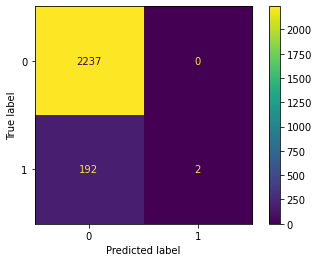

Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      2237
           1       1.00      0.01      0.02       194

    accuracy                           0.92      2431
   macro avg       0.96      0.51      0.49      2431
weighted avg       0.93      0.92      0.88      2431



In [81]:
#Checking the performance

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
result1 = classification_report(y_test, y_pred)
print('Classification Report:',)
print (result1)



In [82]:
result2 = accuracy_score(y_test,y_pred)
print('Accuracy:',result2)

Accuracy: 0.9210201563142739


auc:  0.5051546391752577


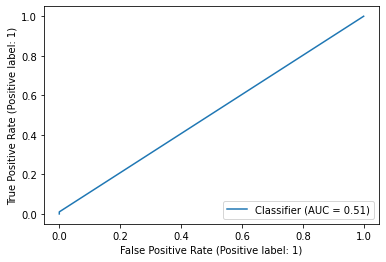

In [83]:
y_pred = clf.predict(X_test)
auc = roc_auc_score(y_test, y_pred)
print ('auc: ',auc)
#2 Plot ROC
roc_curve(y_test, y_pred)
RocCurveDisplay.from_predictions( y_test, y_pred)

In [84]:
# Model explantion
#!pip install shap 
#!pip install warnings
#import shap

In [85]:
# Fits the explainer
#explainer = shap.Explainer(clf.predict, X_test)
#Calculates the SHAP values - It takes some time
#shap_values = explainer(X_test)

In [86]:
#from warnings import filterwarnings
#filterwarnings(action='ignore', category=DeprecationWarning, message='`np.bool` is a deprecated alias')

In [87]:
# setting explainer
#explainer = shap.TreeExplainer(clf)
#shap_values = explainer.shap_values(X,check_additivity=False)
#shap_values

In [88]:
#df.describe()

In [89]:
#Feature importance
#shap.summary_plot(shap_values, X, plot_type='bar')

In [90]:
# summary_plot 
#shap.summary_plot(shap_values, X)

In [91]:
  # visualize the first prediction's explaination
#shap.initjs()
#shap.force_plot(explainer.expected_value, shap_values[0, :], X.iloc[0, :])

In [92]:
#create a SHAP dependence plot to show the effect of a single feature across the whole dataset
#shap.initjs()
#shap.dependence_plot(1, shap_values, X, show=False)
#shap.dependence_plot("UTERINE_HEIGHT", shap_values, X, show=False)

In [93]:
#visualize the training set predictions
#shap.initjs()
#shap.force_plot(explainer.expected_value, shap_values, X)

In [94]:
! pip install lime
import lime
from lime import lime_tabular

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 KB 10.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=f47c0a95103d0efd5e7cf240c1bdb7947b9ed4eb2e3644f91744d221ca71f6fe
  Stored in directory: /root/.cache/pip/wheels/e6/a6/20/cc1e293fcdb67ede666fed293cb895395e7ecceb4467779546
Successfully built lime


In [95]:
import numpy as np
explainer = lime_tabular.LimeTabularExplainer(training_data=np.array(X_train),feature_names=X,class_names=['No','Yes'],mode='classification')

In [96]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train,mode='classification',feature_selection= 'auto',kernel_width=None,feature_names=X, discretize_continuous=True,class_names=['No', 'Yes'])

In [97]:
exp = explainer.explain_instance(data_row=X_test[1],predict_fn=clf.predict_proba,top_labels=1)

exp.show_in_notebook(show_table=True)

In [98]:
exp = explainer.explain_instance(data_row=X_test[30],predict_fn=clf.predict_proba)

exp.show_in_notebook(show_table=True)